# This script computes the Tonic Pain Signature (ToPS) in the UK Biobank cohort

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from neuroCombat import neuroCombat
from confounds import Residualize
import scipy
from scipy.io import loadmat, savemat
import warnings

### Load necessary data

In [2]:
# Load dynamic conditional correlation connectivity dataframe for UK Biobank resting state measurements
brain = pd.read_csv('/Users/Patty/Desktop/EVP_lab/DCC_full.csv')
confounds = pd.read_csv('/Users/Patty/Desktop/EVP_lab/UKB_40K_BrainConfounds.csv')
UKB = pd.read_csv('/Users/Patty/Desktop/EVP_lab/UKB_NoBrain_37k.csv')
UKB = UKB.merge(confounds[['eid','Motion_T2', 'MotionSquared', 'MotionCubed',
     'HeadScaling_T2','HeadScalingSquared_T2', 'HeadScalingCubed_T2',
    'ScannerXposition_T2', 'ScannerYPosition_T2', 'ScannerZPosition_T2']],on='eid')

del confounds

# Derive the spreading risk score
variables = pd.read_csv('/Users/Patty/Desktop/JupyterNB/PLS/0_Variables_V3.csv')
variables = variables[variables.coding_finished==1]
variables_T2 = list((variables['Name'] + '_' + variables['T2']).values)
W = pd.read_csv('/Users/Patty/Desktop/JupyterNB/PLS/Coefficients_PLSReg_3comp.csv')
variables['weights'] = W.Coefficients.values
preproc_UKB_B = pd.read_csv('/Users/Patty/Desktop/JupyterNB/PLS/6_BrainVisit_PreprocFeatures_Adv.csv')
preproc_UKB_B = preproc_UKB_B.dropna(subset = ['eid'])
preproc_UKB_B['eid'] = preproc_UKB_B['eid'].astype(int)
preproc_UKB_B['PLS'] = np.dot(preproc_UKB_B[variables_T2], variables['weights'])

# Loading nodes and edges for Brainnetome atlas
home_dir = '/Users/Patty/Desktop/EVP_lab/'
nodes = pd.read_csv(home_dir + 'Fan_Cluster_279_Details_V2.csv')
edges = pd.read_csv('/Users/Patty/Desktop/EVP_lab/Fan_Cluster_279_Edges_Details_V2.csv')
edges['FCN1'] = [i.split('x')[0] for i in edges.fc_networks]
edges['FCN2'] = [i.split('x')[1] for i in edges.fc_networks]

# Merging PLS score and dummy code scanner site variable
UKB = UKB.merge(preproc_UKB_B[['eid','PLS']],on='eid')
UKB['BinSite_T2'] = np.where(UKB.UKBiobankSite_T2 == 11025.0,1,0)

warnings.filterwarnings('ignore')
tops_w = scipy.io.loadmat('/Users/Patty/Desktop/ToPS/ToPS_weight.mat')['ToPS_w'].T[0]

/Users/Patty/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1744,1746,1748,1749,1750,1751,1777,1778,1779,1780,1781,1782,1783,1784,1785,1786,1787,1794,1795,1796,1797,1798,1799,1802,1804,1830,1908,1909,1910,1911,1912,1913,1914,1915,1916,1917,1918,1919,1920,1921,1922,1923,1924,1925,1926,1927,1928,1929,1930,1931,1965,1966,1967,1968,1969,1970,1971,1972,1973,1975,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2177,2178,2179,2180,2181,2182,2183,2184,2185,2915,2916,2917,2932,2933,2934,2935,2936,2937,2938,2939,2965,2966,2967,2968,2969,2970,2971,2972,2973,2974,2975,2976,2977,2978,2979,2980,2981,2982,2983,2984,2985,2986,2987,2988,2989,2990,2991,2992,2993,2994,2995,299

#### This function does the following: <br> - Residualises confounds from the UKBB functional connectivity data by either 1) regressing the raw confounds from the connectivity data or 2) regressing out confounds which had the number of pain sites regressed out of them <br> - Computes ToPS in the UKBB by taking the dot product of the originally derived signature and the vectors of resting state functional connectivity data of UKBB subjects

#### Confound regression was computed using the following package: https://pypi.org/project/confounds/

In [5]:
def ToPS_corr(data,name='FPN',tops_thresh=5,method='residuals',networks=False):
    
    tops_thresh = 100 - tops_thresh
    ToPS_w = np.where(abs(tops_w) > np.percentile(abs(tops_w),  tops_thresh), tops_w, 0)
    ToPS_w = pd.DataFrame(ToPS_w,columns=['tops'])
    
    if networks == True:
        tops_net = pd.concat([ToPS_w,edges[['names','fc_networks','FCN1','FCN2']]],axis=1)
        tops_net_ = tops_net[tops_net.fc_networks.str.contains(name)]
        data = pd.concat([data[tops_net_.names],
                          data.eid],axis=1)
        ToPS_w = tops_net_.tops
    
    #Merge vars of interest
    var_cols = ['ChronicPain_T2','NumberPainTypesLastMonth_T2',
        'PLS','Motion_T2', 'MotionSquared', 'MotionCubed',
        'HeadScaling_T2','HeadScalingSquared_T2', 'HeadScalingCubed_T2',
        'ScannerXposition_T2', 'ScannerYPosition_T2', 'ScannerZPosition_T2',
        'BinSite_T2', 'Sex_T0','eid']
    conf_cols = ['Motion_T2', 'MotionSquared', 'MotionCubed',
        'HeadScaling_T2', 'HeadScalingSquared_T2', 'HeadScalingCubed_T2',
        'ScannerXposition_T2', 'ScannerYPosition_T2', 'ScannerZPosition_T2',
        'BinSite_T2']
    data = data.merge(UKB[var_cols], on='eid')
    data = data.dropna()
    
    #Feature and target variables
    X = data.drop(columns=var_cols)
    y = data.NumberPainTypesLastMonth_T2

    #Variables for combat
    tops_vars = data[['PLS','Motion_T2','NumberPainTypesLastMonth_T2','Sex_T0']]
    confounds = data[conf_cols]
    covar = data[['NumberPainTypesLastMonth_T2'] + conf_cols]
    idx = data['eid']
    
    #Regress covariates
    if method == 'combat':

        x_combat = neuroCombat(dat=x_train.T, covars=covar_train, 
                               batch_col = 'NumberPainTypesLastMonth_T2', 
                               eb=False,
                               parametric=True,
                               mean_only=True)['data'].T

        resid = Residualize()
        resid.fit(x_combat, confounds_train)
        X_train = resid.transform(x_train, confounds_train)
        X_test = resid.transform(x_test, confounds_test)

    if method == 'residuals':  # Regressing the raw confounds from functional connectivity

        resid = Residualize()
        resid.fit(X, confounds)
        X = resid.transform(X, confounds)

    if method == 'double':  # Regressing the confounds orthogonal to pain from functional connectivity

        resid = Residualize()
        resid.fit(confounds, y)
        C = resid.transform(confounds, y)

        resid = Residualize()
        resid.fit(X, confounds)
        X = resid.transform(X, C)          

    if method == 'raw':

        X.reset_index(drop=True,inplace=True)
            
    #Calculate ToPS
#     ToPS = np.round(np.nansum(np.multiply(X, ToPS_w.values.T), axis = 1), 5)
#     data = pd.DataFrame(X)
#     tops_vars.reset_index(drop=True,inplace=True)
#     data = pd.concat([data,tops_vars],axis=1,ignore_index=True)
#     data = data.rename(columns=dict(zip([38781,38782,38783],['PLS','Motion_T2','NumberPainTypesLastMonth_T2'])))
#     data['ToPS'] = ToPS
    ToPS = np.round(np.nansum(np.multiply(X, ToPS_w.values.T), axis = 1), 5)
    tops_vars['ToPS'] = ToPS
    tops_vars['eid'] = data['eid']
    if networks == True:
        tops_vars['network'] = name
    
    #Compute correlations
    NCP = tops_vars['ToPS'].corr(tops_vars['NumberPainTypesLastMonth_T2'])
    PLS = tops_vars['ToPS'].corr(tops_vars['PLS'])
    Motion = tops_vars['ToPS'].corr(tops_vars['Motion_T2'])
    
    #Correlation DF
    corr_df = pd.DataFrame({'Num Pain Types':[NCP], 'Risk Score':[PLS], 'Motion':[Motion]}, index=[name])
    
    #ToPS and vars DF
    tops_df = pd.DataFrame(ToPS)
    idx = idx.reset_index(drop=True)
    tops_df = pd.concat([tops_df,idx,tops_vars],axis=1)
    tops_df = tops_df.rename(columns=dict(zip([0],['ToPS'])))

    return corr_df, tops_vars


In [10]:
# Compute ToPS using normal regression with top 5% of strongest weights
norm_regr_5 = ToPS_corr(brain,name=None,tops_thresh=5,method='residuals',networks=False)

# Compute ToPS using double regression with top 5% of strongest weights
double_regr_5 = ToPS_corr(brain,name=None,tops_thresh=5,method='double',networks=False)

### Comparison of double vs normal regression of confounds

Text(0.5, 1.0, 'Double Regression of Confounds')

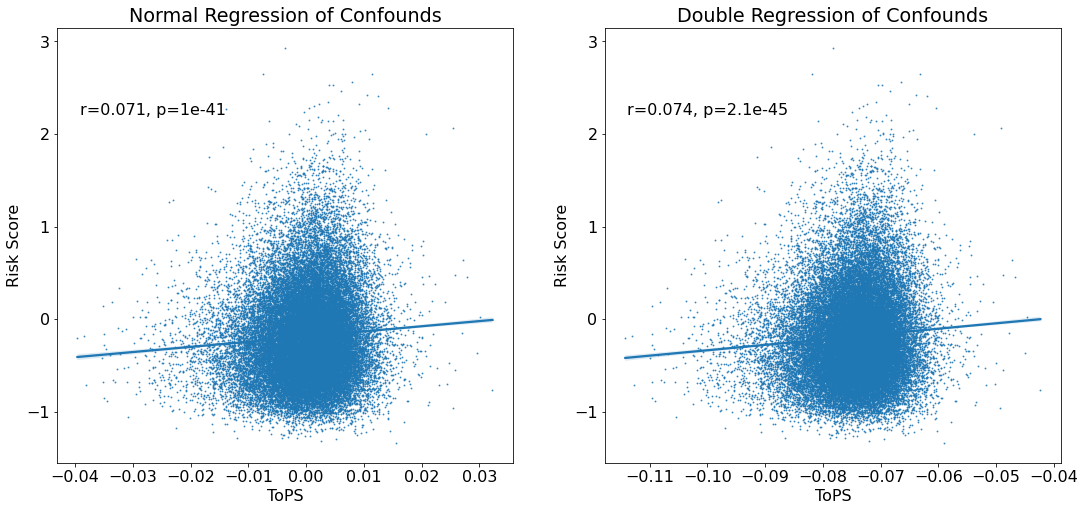

In [114]:
from scipy.stats import pearsonr
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,8))
ax1 = ax[0]
ax2 = ax[1]
sns.regplot(data=norm_regr_5[1],x='ToPS',y='Risk Score',scatter_kws={'s':0.75},ax = ax1)
sns.regplot(data=double_regr_5[1],x='ToPS',y='Risk Score',scatter_kws={'s':0.75},ax = ax2)

r,p = pearsonr(norm_regr_5[1]['ToPS'],norm_regr_5[1]['Risk Score'])
ax1.text(.05, .8, 'r={:.3f}, p={:.2g}'.format(r, p),
            transform=ax1.transAxes)

r,p = pearsonr(double_regr_5[1]['ToPS'],double_regr_5[1]['Risk Score'])
ax2.text(.05, .8, 'r={:.3f}, p={:.2g}'.format(r, p),
            transform=ax2.transAxes)


ax1.set_title('Normal Regression of Confounds')
ax2.set_title('Double Regression of Confounds')